In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

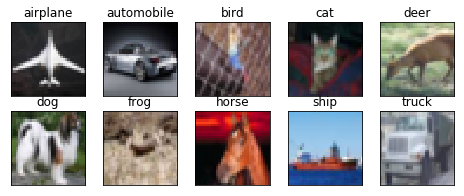

In [106]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [110]:
print(num_classes)

10


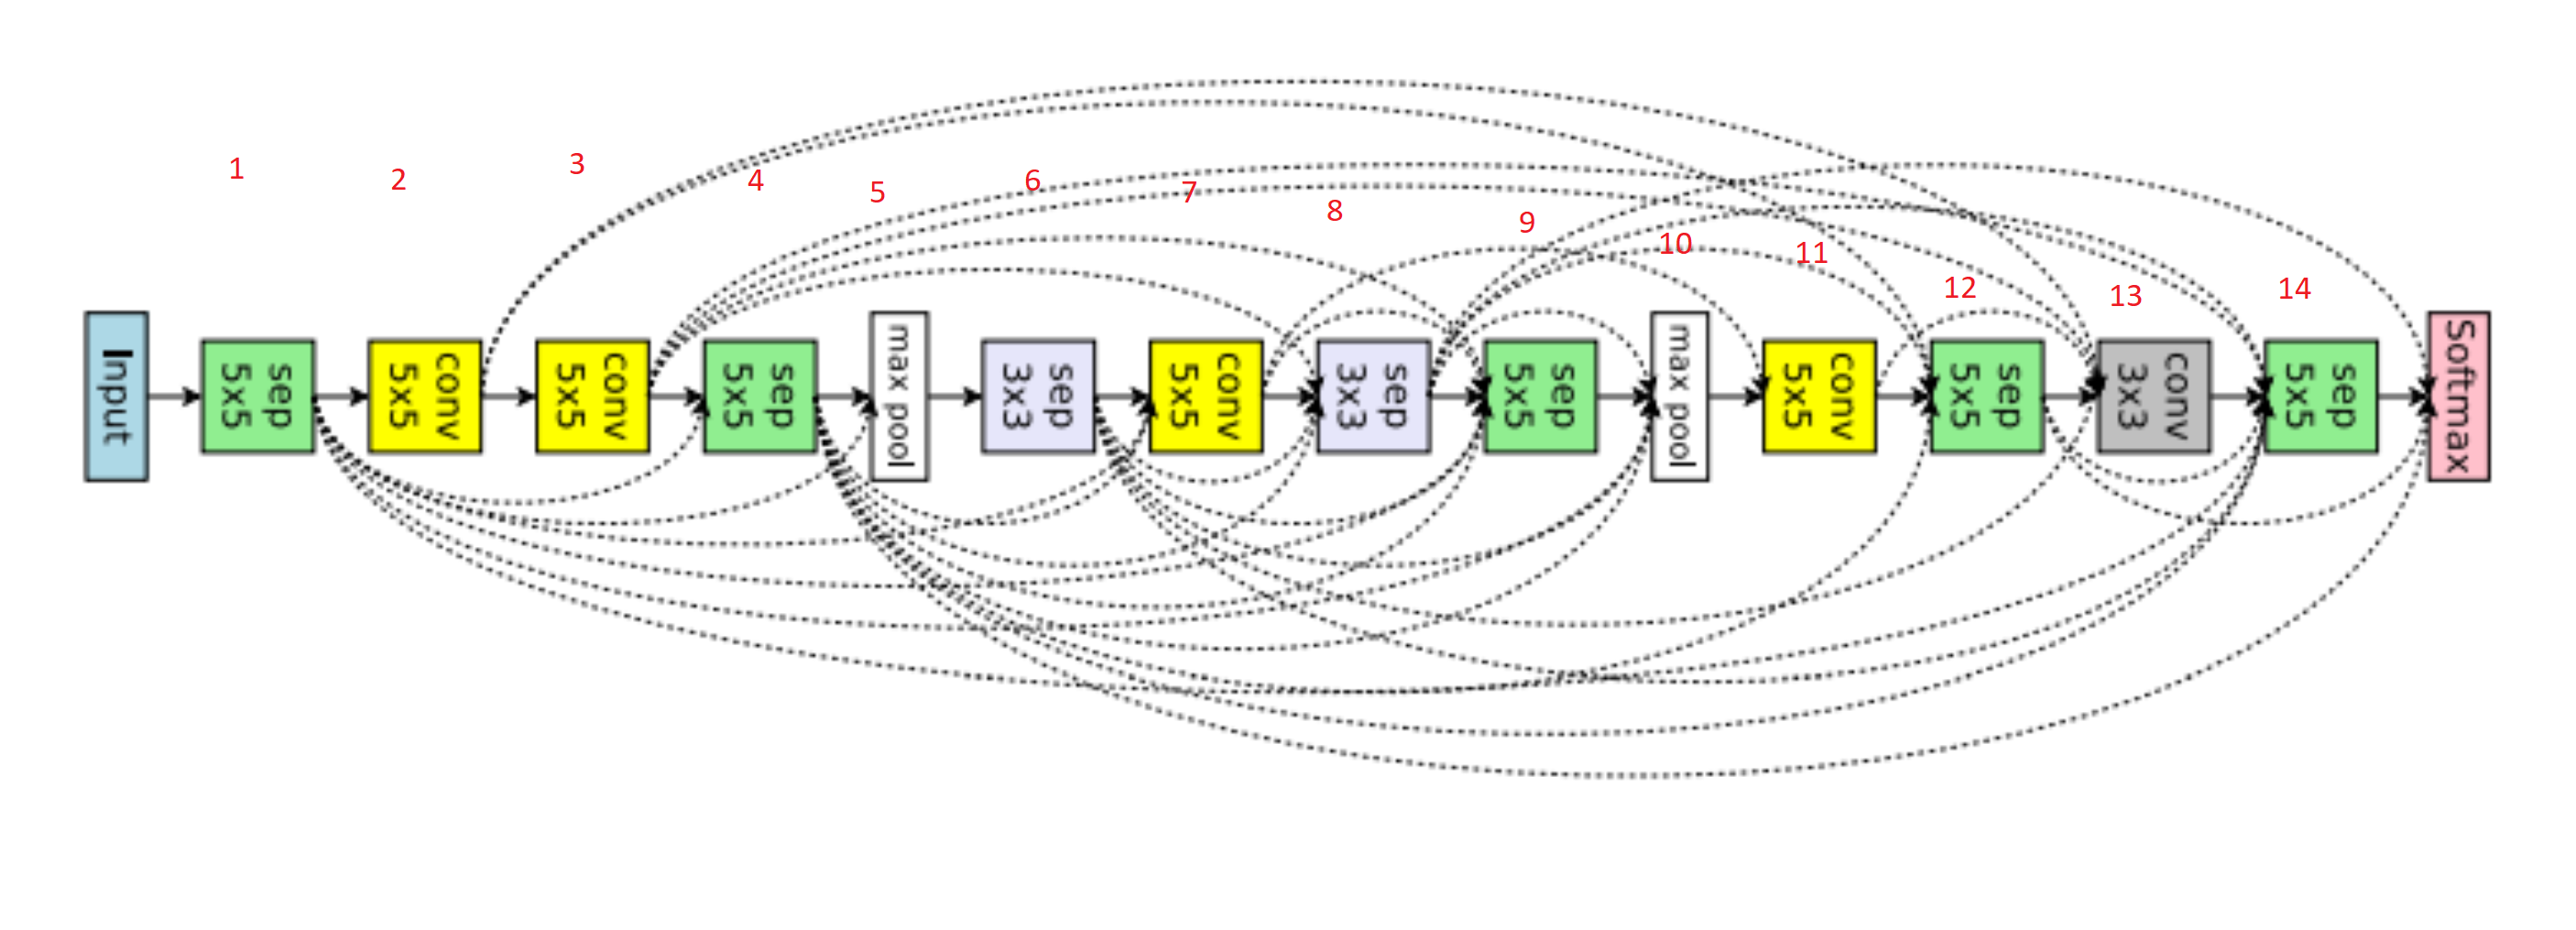

In [111]:
from IPython.display import Image, display
display(Image('CIFAR10.png', width=1000, height=300))
#<img src="CIFAR10.png" alt="Drawing" style="width: 200px;"/>

In [0]:
# from keras.layers import Lambda

# def space_to_depth_x2(x):
#     return tf.space_to_depth(x, block_size=2) 

In [113]:
import keras
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Input
from keras.utils import plot_model
from keras.models import Model
# from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate, UpSampling2D

visible = Input(shape=(32,32,3))

# 1. Depth wise separable Convolution - 5x5

conv1 = SeparableConv2D(10, (5,5), activation='relu', name ='L1_Sep2D')(visible)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(.2)(conv1)

# 2. Normal Convolution - 5x5

conv2 = Conv2D(10, (5,5), activation='relu', padding="same", name ='L2_Conv2D')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(.2)(conv2)

# 3. Normal Convolution - 5x5

conv3 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L3_Conv2D')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(.2)(conv3)

# 4. Depth wise separable Convolution - 5x5

L4_added_1 = concatenate([conv1, conv3], name ='L4_concatenate')

conv4 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L4_Sep2D')(L4_added_1)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(.2)(conv4)

# 5. MaxPool

L5_added_1 = concatenate([conv1, conv4], name ='L5_concatenate')

L5_pool_1 = MaxPooling2D(pool_size=(2, 2), name ='L5_MP')(L5_added_1)

L5_Conv = Conv2D(10, (1,1), activation='relu', padding="same", name ='L5_Conv2_BottleNeck')(L5_pool_1)

L5_pool = UpSampling2D(size=(2, 2), name ='L5_UpScaling')(L5_Conv)

# 6. Depth wise separable Convolution - 3x3

conv6 = SeparableConv2D(16, (3,3), activation='relu', padding="same", name ='L6_Sep2D')(L5_pool)
conv6 = BatchNormalization()(conv6)
conv6 = Dropout(.2)(conv6)

# 7. Normal Convolution - 5x5

L7_added_1 = concatenate([conv4, conv6, conv1], name ='L7_Concatenate')

conv7 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L7_Conv2D')(L7_added_1)
conv7 = BatchNormalization()(conv7)
conv7 = Dropout(.2)(conv7)

# 8. Depth wise separable Convolution - 3x3

L8_added_1 = concatenate([conv3, conv7, conv6, conv4], name ='L8_Concatenate')

conv8 = SeparableConv2D(16, (3,3), activation='relu', padding="same", name ='L8_Sep2D')(L8_added_1)
conv8 = BatchNormalization()(conv8)
conv8 = Dropout(.2)(conv8)

# 9. Depth wise separable Convolution - 5x5

L9_added_1 = concatenate([conv7, conv8, conv3, conv6, conv4, conv1], name ='L9_Concatenate')

conv9 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L9_Sep2D')(L9_added_1)
conv9 = BatchNormalization()(conv9)
conv9 = Dropout(.2)(conv9)

# 10. MaxPool

L10_added_1 = concatenate([conv8, conv9, conv6, conv1, conv4], name ='L10_Concatenate')

L10_pool_1 = MaxPooling2D(pool_size=(2, 2), name ='L10_MP')(L10_added_1)

L10_Conv = Conv2D(10, (1,1), activation='relu', padding="same", name ='L10_Con2D_BottleNeck')(L10_pool_1)

L10_pool = UpSampling2D(size=(2, 2), name ='L10_UpScaling')(L10_Conv)

# 11. Normal Convolution - 5x5

L11_added_1 = concatenate([conv7, L10_pool], name ='L11_Concatenate')

conv11 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L11_Conv2D')(L11_added_1)
conv11 = BatchNormalization()(conv11)
conv11 = Dropout(.2)(conv11)

# 12. Depth wise separable Convolution - 5x5

L12_added_1 = concatenate([conv8, conv11, conv2, conv1], name ='L12_Concatenate')

conv12 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L12_Sep2D')(L12_added_1)
conv12 = BatchNormalization()(conv12)
conv12 = Dropout(.2)(conv12)

# 13. Normal Convolution - 3x3

L13_added_1 = concatenate([conv11, conv12, conv3, conv2, conv6], name ='L13_Concatenate')

conv13 = Conv2D(16, (3,3), activation='relu', padding="same", name ='L13_Conv2D')(L13_added_1)
conv13 = BatchNormalization()(conv13)
conv13 = Dropout(.2)(conv13)

# 14. Depth wise separable Convolution - 5x5

L14_added_1 = concatenate([conv3, conv13, conv8, conv12, conv4, conv6, conv1], name ='L14_Concatenate')

conv14 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L14_Sep2D')(L14_added_1)
conv14 = BatchNormalization()(conv14)
conv14 = Dropout(.2)(conv14)

# 15. Softmax

L15_added_1 = concatenate([conv8, conv14, conv12, conv4], name ='L15_Concatenate')

conv15 = Conv2D(10, (1,1), name ='L15_Conv2D_BottleNeck')(L15_added_1)

conv16 = Conv2D(num_classes, (28,28), name ='L15_Conv2D')(conv15)

flat = Flatten()(conv16)

output = Activation('softmax')(flat)

model = Model(inputs=visible, outputs=output)
 
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

#summarize layers
print(model.summary())

#plot graph
plot_model(model, to_file='model_plot.jpg', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L1_Sep2D (SeparableConv2D)      (None, 28, 28, 10)   115         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 28, 28, 10)   40          L1_Sep2D[0][0]                   
__________________________________________________________________________________________________
dropout_114 (Dropout)           (None, 28, 28, 10)   0           batch_normalization_114[0][0]    
__________________________________________________________________________________________________
L2_Conv2D 

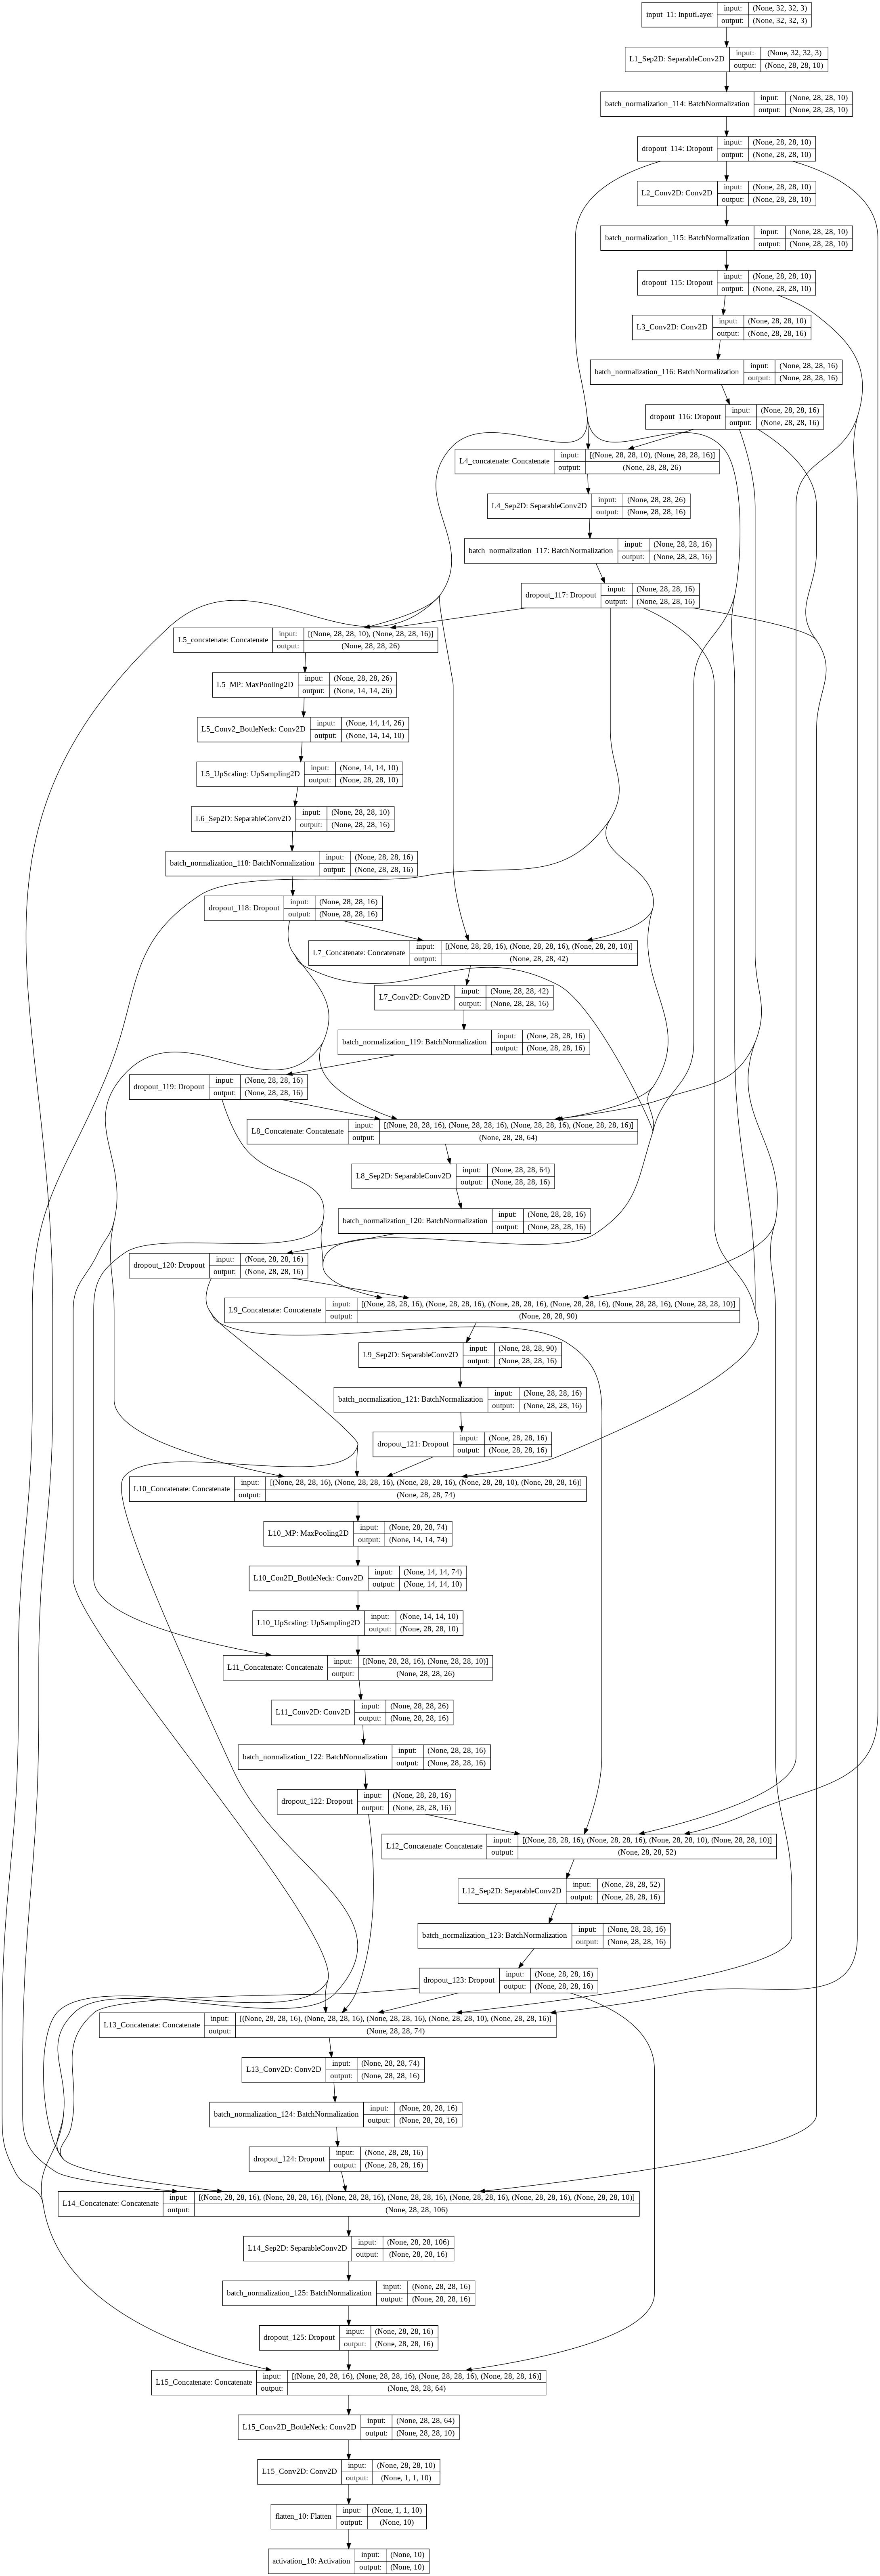

In [114]:
from IPython.display import Image, display
display(Image('model_plot.jpg'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 40s 104ms/step - loss: 0.3299 - acc: 0.8896 - val_loss: 0.3007 - val_acc: 0.8944

Epoch 00001: val_acc improved from -inf to 0.89443, saving model to model_accuracy.best.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 30s 78ms/step - loss: 0.2773 - acc: 0.8987 - val_loss: 0.2683 - val_acc: 0.9013

Epoch 00002: val_acc improved from 0.89443 to 0.90134, saving model to model_accuracy.best.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 30s 77ms/step - loss: 0.2571 - acc: 0.9034 - val_loss: 0.2710 - val_acc: 0.9000

Epoch 00003: val_acc did not improve from 0.90134
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 30s 77ms/step - loss: 0.2

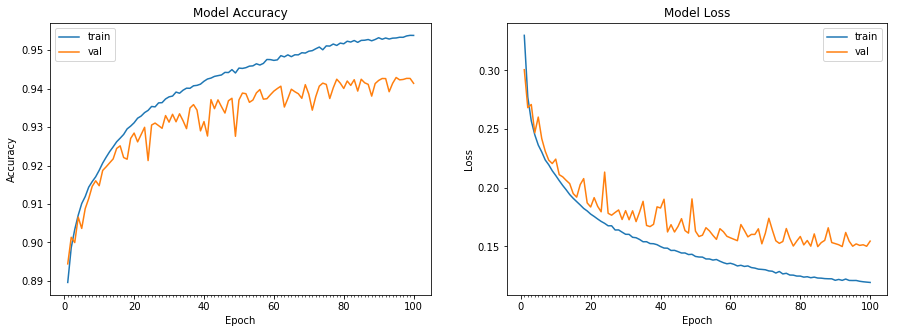

Accuracy on test data is: 67.95


In [115]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(zoom_range=0.0,
                            horizontal_flip=False)

# Accuracy on test data is: 83.88
# def scheduler(epoch, lr):
#   return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Accuracy on test data is: 83.48
def lr_schedule(epoch):
   lrate = 0.001
   if epoch > 75:
       lrate = 0.0005
   if epoch > 100:
       lrate = 0.0003
   return lrate

filepath="model_accuracy.best.hdf5"

reduce_LR = LearningRateScheduler(lr_schedule, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                samples_per_epoch = train_features.shape[0], nb_epoch = 100,
                                validation_data = (test_features, test_labels), verbose=1,
                               callbacks=[reduce_LR, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [116]:
import keras
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Input
from keras.utils import plot_model
from keras.models import Model
# from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate, UpSampling2D

visible = Input(shape=(32,32,3))

# 1. Depth wise separable Convolution - 5x5

conv1 = SeparableConv2D(10, (5,5), activation='relu', name ='L1_Sep2D')(visible)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(.2)(conv1)

# 2. Normal Convolution - 5x5

conv2 = Conv2D(10, (5,5), activation='relu', padding="same", name ='L2_Conv2D')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(.2)(conv2)

# 3. Normal Convolution - 5x5

conv3 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L3_Conv2D')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(.2)(conv3)

# 4. Depth wise separable Convolution - 5x5

L4_added_1 = concatenate([conv1, conv3], name ='L4_concatenate')

conv4 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L4_Sep2D')(L4_added_1)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(.2)(conv4)

# 5. MaxPool

L5_added_1 = concatenate([conv1, conv4], name ='L5_concatenate')

L5_pool_1 = MaxPooling2D(pool_size=(2, 2), name ='L5_MP')(L5_added_1)

L5_Conv = Conv2D(10, (1,1), activation='relu', padding="same", name ='L5_Conv2_BottleNeck')(L5_pool_1)

L5_pool = UpSampling2D(size=(2, 2), name ='L5_UpScaling')(L5_Conv)

# 6. Depth wise separable Convolution - 3x3

conv6 = SeparableConv2D(16, (3,3), activation='relu', padding="same", name ='L6_Sep2D')(L5_pool)
conv6 = BatchNormalization()(conv6)
conv6 = Dropout(.2)(conv6)

# 7. Normal Convolution - 5x5

L7_added_1 = concatenate([conv4, conv6, conv1], name ='L7_Concatenate')

conv7 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L7_Conv2D')(L7_added_1)
conv7 = BatchNormalization()(conv7)
conv7 = Dropout(.2)(conv7)

# 8. Depth wise separable Convolution - 3x3

L8_added_1 = concatenate([conv3, conv7, conv6, conv4], name ='L8_Concatenate')

conv8 = SeparableConv2D(16, (3,3), activation='relu', padding="same", name ='L8_Sep2D')(L8_added_1)
conv8 = BatchNormalization()(conv8)
conv8 = Dropout(.2)(conv8)

# 9. Depth wise separable Convolution - 5x5

L9_added_1 = concatenate([conv7, conv8, conv3, conv6, conv4, conv1], name ='L9_Concatenate')

conv9 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L9_Sep2D')(L9_added_1)
conv9 = BatchNormalization()(conv9)
conv9 = Dropout(.2)(conv9)

# 10. MaxPool

L10_added_1 = concatenate([conv8, conv9, conv6, conv1, conv4], name ='L10_Concatenate')

L10_pool_1 = MaxPooling2D(pool_size=(2, 2), name ='L10_MP')(L10_added_1)

L10_Conv = Conv2D(10, (1,1), activation='relu', padding="same", name ='L10_Con2D_BottleNeck')(L10_pool_1)

L10_pool = UpSampling2D(size=(2, 2), name ='L10_UpScaling')(L10_Conv)

# 11. Normal Convolution - 5x5

L11_added_1 = concatenate([conv7, L10_pool], name ='L11_Concatenate')

conv11 = Conv2D(16, (5,5), activation='relu', padding="same", name ='L11_Conv2D')(L11_added_1)
conv11 = BatchNormalization()(conv11)
conv11 = Dropout(.2)(conv11)

# 12. Depth wise separable Convolution - 5x5

L12_added_1 = concatenate([conv8, conv11, conv2, conv1], name ='L12_Concatenate')

conv12 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L12_Sep2D')(L12_added_1)
conv12 = BatchNormalization()(conv12)
conv12 = Dropout(.2)(conv12)

# 13. Normal Convolution - 3x3

L13_added_1 = concatenate([conv11, conv12, conv3, conv2, conv6], name ='L13_Concatenate')

conv13 = Conv2D(16, (3,3), activation='relu', padding="same", name ='L13_Conv2D')(L13_added_1)
conv13 = BatchNormalization()(conv13)
conv13 = Dropout(.2)(conv13)

# 14. Depth wise separable Convolution - 5x5

L14_added_1 = concatenate([conv3, conv13, conv8, conv12, conv4, conv6, conv1], name ='L14_Concatenate')

conv14 = SeparableConv2D(16, (5,5), activation='relu', padding="same", name ='L14_Sep2D')(L14_added_1)
conv14 = BatchNormalization()(conv14)
conv14 = Dropout(.2)(conv14)

# 15. Softmax

L15_added_1 = concatenate([conv8, conv14, conv12, conv4], name ='L15_Concatenate')

conv15 = Conv2D(10, (1,1), name ='L15_Conv2D_BottleNeck')(L15_added_1)

conv16 = Conv2D(num_classes, (28,28), name ='L15_Conv2D')(conv15)

flat = Flatten()(conv16)

output = Activation('softmax')(flat)

model = Model(inputs=visible, outputs=output)
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#summarize layers
print(model.summary())

#plot graph
plot_model(model, to_file='model_plot.jpg', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L1_Sep2D (SeparableConv2D)      (None, 28, 28, 10)   115         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_126 (BatchN (None, 28, 28, 10)   40          L1_Sep2D[0][0]                   
__________________________________________________________________________________________________
dropout_126 (Dropout)           (None, 28, 28, 10)   0           batch_normalization_126[0][0]    
__________________________________________________________________________________________________
L2_Conv2D 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 44s 112ms/step - loss: 1.7784 - acc: 0.3954 - val_loss: 1.8007 - val_acc: 0.4085

Epoch 00001: val_acc improved from -inf to 0.40850, saving model to model_accuracy.best.hdf5
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 31s 80ms/step - loss: 1.3607 - acc: 0.5225 - val_loss: 1.4458 - val_acc: 0.5218

Epoch 00002: val_acc improved from 0.40850 to 0.52180, saving model to model_accuracy.best.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 31s 80ms/step - loss: 1.1514 - acc: 0.5950 - val_loss: 1.1380 - val_acc: 0.6151

Epoch 00003: val_acc improved from 0.52180 to 0.61510, saving model to model_accuracy.best.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
390/390 [=============

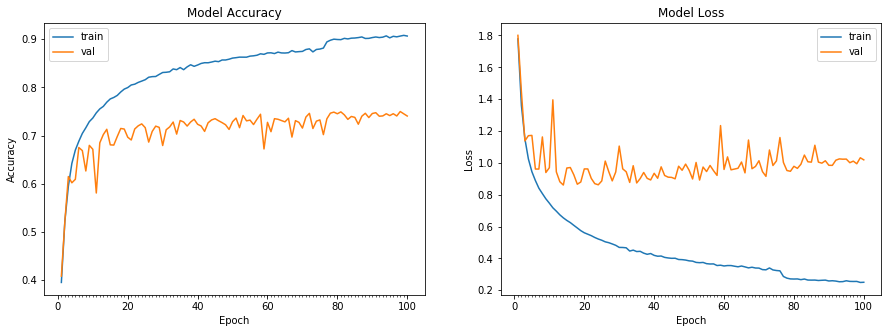

Accuracy on test data is: 74.07


In [117]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

datagen = ImageDataGenerator(zoom_range=0.0,
                            horizontal_flip=False)

# Accuracy on test data is: 83.88
# def scheduler(epoch, lr):
#   return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# Accuracy on test data is: 83.48
def lr_schedule(epoch):
   lrate = 0.001
   if epoch > 75:
       lrate = 0.0005
   if epoch > 100:
       lrate = 0.0003
   return lrate

filepath="model_accuracy.best.hdf5"

reduce_LR = LearningRateScheduler(lr_schedule, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                samples_per_epoch = train_features.shape[0], nb_epoch = 100,
                                validation_data = (test_features, test_labels), verbose=1,
                               callbacks=[reduce_LR, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))